#Problem: Use clustering in the information retrieval process. Select at least 10K movie plots. First, embed all movie in a vector space (see below), then cluster them and compute the cluster centroids. Embed your queries in the same vector space as documents (very important). The retrieval algorithm will:

#Find the closest cluster(s) to your query computed as the distance between the query vector and cluster centroids (use a threshold to select a small number of clusters closest to your query). From the selected clusters select the closest 5 movies to your query. Compute the precision in top 5 results.

In [357]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse

In [358]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [359]:
%cd /content/drive/MyDrive/TextMining
%ls *.csv

/content/drive/MyDrive/TextMining
wiki_movie_plots_deduped.csv


In [360]:
dir_file = os.getcwd() # returns path to current directory
files_dir = os.listdir(dir_file)  # list of files in current directory

csv_files = [f for f in files_dir if f.endswith('csv')]
print(csv_files)
movie_file = csv_files[0]

movie_df = pd.read_csv(movie_file)
print(movie_df.columns)  # the columns
print(movie_df.shape)

['wiki_movie_plots_deduped.csv']
Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')
(34886, 8)


In [361]:
# Increase the number of rows Pandas displays
import pandas as pd
pd.set_option('display.max_rows', None)

# Print all the rows of the value counts
print(movie_df['Genre'].value_counts())


Genre
unknown                                                                              6083
drama                                                                                5964
comedy                                                                               4379
horror                                                                               1167
action                                                                               1098
thriller                                                                              966
romance                                                                               923
western                                                                               865
crime                                                                                 568
adventure                                                                             526
musical                                                                               467
crim

In [362]:
# Get the top 35 genres
top_genres = movie_df['Genre'].value_counts().head(11).index.tolist()[1:]
# Display the array
print(top_genres)

['drama', 'comedy', 'horror', 'action', 'thriller', 'romance', 'western', 'crime', 'adventure', 'musical']


#Select 10k Movie Plots

In [363]:
# Get the top 35 genres
select_movies = movie_df[['Title', 'Plot', 'Genre']]#[movie_df['Genre'].isin(top_genres)]
select_movies.head()
print(len(select_movies))

34886


#1. Embed the movies using:

##(a) tf vector space (eliminate as many uninformative words as possible). You should expect that the number of terms will still be large;

In [364]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [365]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatizer_preprocessor(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

# Updated vectorizer
vectorizer = TfidfVectorizer(
    #max_df=0.8,  # Reduce common term inclusion
    #min_df=2,    # Exclude very rare terms
    #ngram_range=(1, 2),
    max_features=5000,
    #preprocessor=lemmatizer_preprocessor,
    #stop_words="english",
    #sublinear_tf=True
)

# Apply TF-IDF transformation
X_tfidf = vectorizer.fit_transform(select_movies['Plot'])  # Replace 'Plot' with your column name

#Check Sparsity

In [366]:
sparsity = (1.0 - X_tfidf.nnz / float(X_tfidf.shape[0] * X_tfidf.shape[1])) * 100
print(f"Sparsity of the TF-IDF matrix: {sparsity:.2f}%")

Sparsity of the TF-IDF matrix: 99.86%


## (b) Attempt reducing the dimensionality with the SVD method (keep at least 80-90 variance of the original data)

In [367]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.pipeline import make_pipeline

# Perform SVD and normalization
scaler = StandardScaler(with_mean=False)
svd = TruncatedSVD(n_components=200, random_state=42)  # Tune n_components as needed
normalizer = Normalizer(copy=False)

# Create pipeline
lsa = make_pipeline(scaler,svd,normalizer)

# Apply the pipeline to the TF-IDF matrix
X_reduced = lsa.fit_transform(X_tfidf)

# Check explained variance
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance: {explained_variance:.2f}")

Explained variance: 0.03


#Elbow Method analysis for K-Means

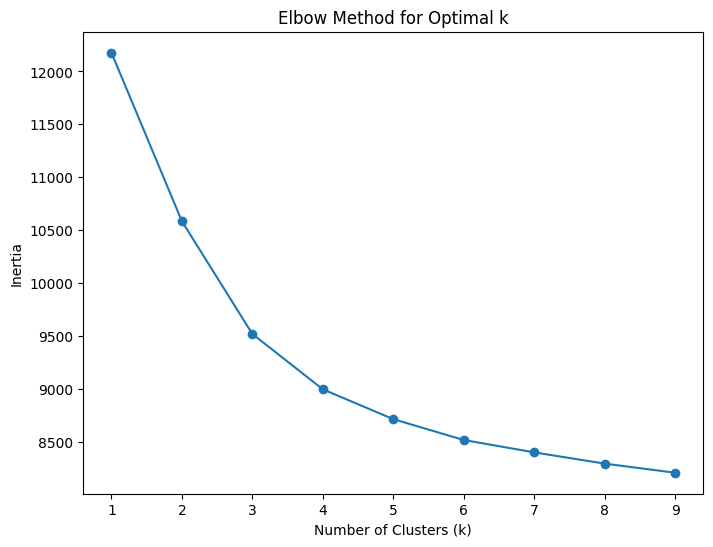

In [368]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reduced)  # Use scaled feature matrix
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

#Silhouette Score Analysis for K means

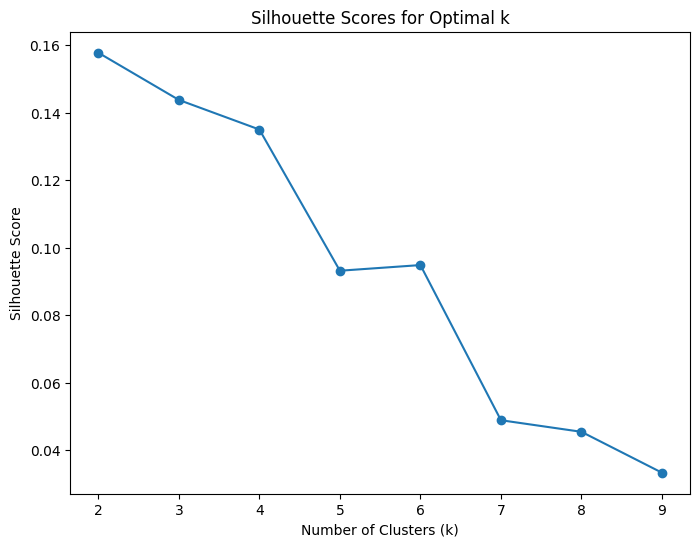

In [369]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10):  # k must be at least 2 for silhouette
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reduced)
    silhouette_scores.append(silhouette_score(X_reduced, kmeans.labels_))

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


#Dendrogram Analysis of Agglomerate Clustering

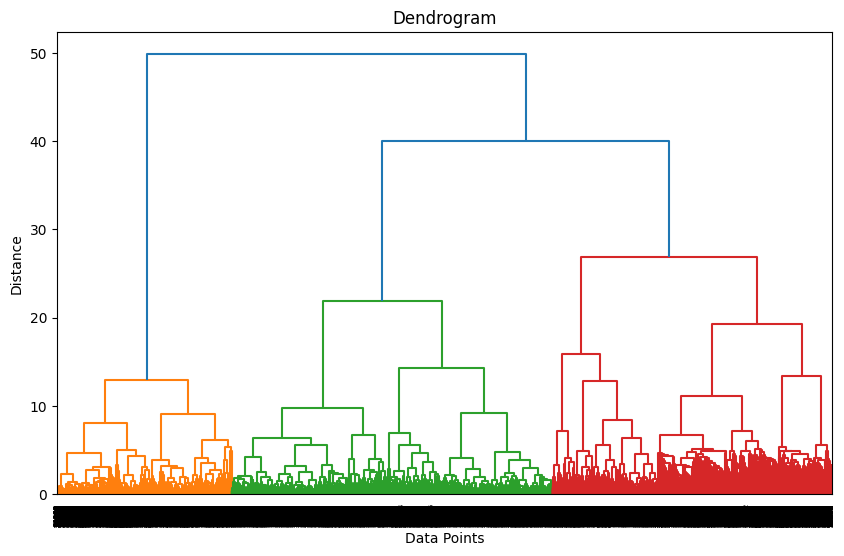

In [370]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate linkage matrix
linkage_matrix = linkage(X_reduced, method='ward')  # Use 'ward' for minimizing variance

# Plot dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


#Silhouette Score Analysis for Agglomerate Clustering

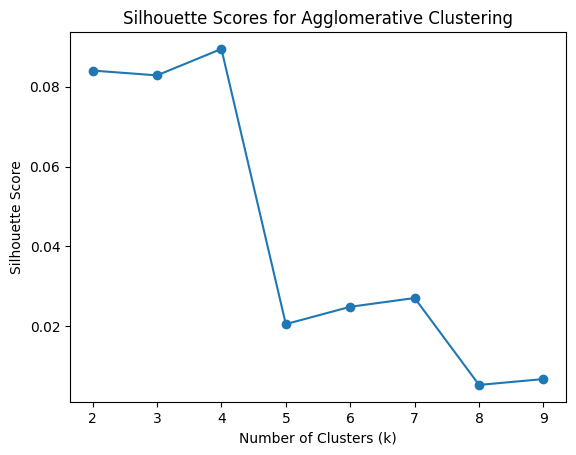

In [371]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10):  # Try different cluster counts
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()



#2. Cluster all texts using:

In [372]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_purity(cluster_labels, true_labels):
    # Create a contingency table (confusion matrix)
    contingency_matrix = confusion_matrix(true_labels, cluster_labels)

    # Calculate purity
    majority_sum = np.sum(np.max(contingency_matrix, axis=0))
    total_samples = np.sum(contingency_matrix)
    purity = majority_sum / total_samples
    return purity

##(a) k-means

In [412]:
from nltk.cluster import KMeansClusterer
from nltk.cluster.util import cosine_distance

num_clustersK = 4
num_clustersA = 4

# Use NLTK KMeansClusterer
kmeans = KMeansClusterer(
    num_clustersK,
    distance=cosine_distance,
    repeats = 25,
    avoid_empty_clusters=True
)

In [413]:
# Train the KMeans model
cluster_labels = kmeans.cluster(X_reduced, assign_clusters=True)
select_movies['Cluster_KMeans_NLTK'] = cluster_labels

<ipython-input-413-13bed27aabcf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_movies['Cluster_KMeans_NLTK'] = cluster_labels


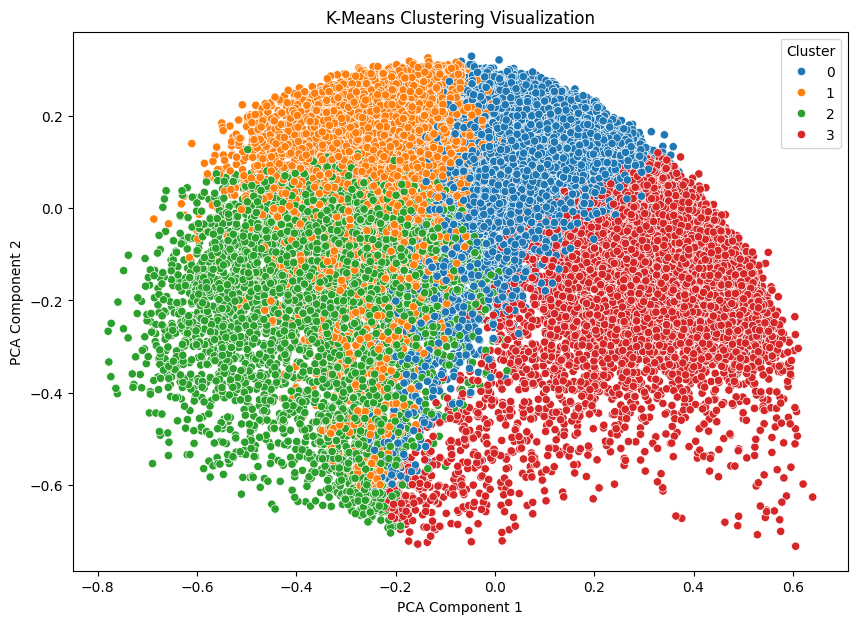

In [414]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_reduced)  # Use the reduced data from your pipeline

# Create a scatter plot with cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=cluster_labels,  # Use cluster labels from KMeans
    palette='tab10',
    legend='full'
)

# Add labels and title
plt.title("K-Means Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.show()


In [376]:
# Group the movies by their cluster labels
clustered_movies = select_movies.groupby('Cluster_KMeans_NLTK')

# Analyze the genres in each cluster
for cluster_label, group in clustered_movies:
    print(f"\nCluster {cluster_label}:")
    print(group['Genre'].value_counts())



Cluster 0:
Genre
drama                                                                                3914
comedy                                                                               3323
unknown                                                                              1476
horror                                                                                641
thriller                                                                              563
western                                                                               522
crime                                                                                 429
musical                                                                               398
crime drama                                                                           362
romantic comedy                                                                       358
film noir                                                                         

In [377]:
# Assuming `true_labels` contains the ground truth labels
from sklearn.preprocessing import LabelEncoder

# Encode true labels (genres) as integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(select_movies['Genre'])
#true_labels_encoded = label_encoder.fit_transform(select_movies['Genre'])


# Verify the mapping
print("Genre Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

purity = calculate_purity(cluster_labels, true_labels_encoded)
print(f"Purity: {purity:.4f}")

Genre Mapping: {' ': 0, ' usa ': 1, ' usa, can ': 2, '-': 3, '16\xa0mm film': 4, '[140]': 5, '[144]': 6, 'action': 7, 'action ': 8, 'action & comedy': 9, 'action & love': 10, 'action & romance': 11, 'action (film genre)': 12, 'action - comedy': 13, 'action - romance': 14, 'action - superhero ': 15, 'action - thriller': 16, 'action - war': 17, 'action / adventure': 18, 'action / adventure / comedy': 19, 'action / adventure / comedy / crime / drama': 20, 'action / adventure / kung fu': 21, 'action / adventure / martial arts': 22, 'action / adventure / suspense': 23, 'action / adventure / thriller': 24, 'action / animation / adventure': 25, 'action / biography / history / war / costume': 26, 'action / comedy': 27, 'action / comedy / crime': 28, 'action / comedy / drama': 29, 'action / comedy / fantasy': 30, 'action / comedy / romance': 31, 'action / comedy / thriller': 32, 'action / crime': 33, 'action / crime / adventure': 34, 'action / crime / comedy': 35, 'action / crime / drama': 36, 

##(b) hierarchical agglomerative clustering algorithms (try 'ward'/'complete'/'average' linkage with 'euclidean'/'cosine' distances. Determine a good number of clusters and the method that gives you a better purity result.

#Using ward

##Euclidean

In [378]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np

# Step 1: Perform hierarchical clustering
# Use 'ward' linkage and 'euclidean' distance
linkage_matrix = linkage(X_reduced, method='ward', metric='euclidean')
cluster_labels = fcluster(linkage_matrix, t=num_clustersA, criterion='maxclust')

In [379]:
# Assuming `true_labels` contains the ground truth labels
from sklearn.preprocessing import LabelEncoder

# Encode true labels (genres) as integers
label_encoder = LabelEncoder()
#true_labels_encoded = label_encoder.fit_transform(movie_df['Mapped_Genre'])
true_labels_encoded = label_encoder.fit_transform(select_movies['Genre'])


# Verify the mapping
print("Genre Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

purity = calculate_purity(cluster_labels, true_labels_encoded)
print(f"Purity: {purity:.4f}")

Genre Mapping: {' ': 0, ' usa ': 1, ' usa, can ': 2, '-': 3, '16\xa0mm film': 4, '[140]': 5, '[144]': 6, 'action': 7, 'action ': 8, 'action & comedy': 9, 'action & love': 10, 'action & romance': 11, 'action (film genre)': 12, 'action - comedy': 13, 'action - romance': 14, 'action - superhero ': 15, 'action - thriller': 16, 'action - war': 17, 'action / adventure': 18, 'action / adventure / comedy': 19, 'action / adventure / comedy / crime / drama': 20, 'action / adventure / kung fu': 21, 'action / adventure / martial arts': 22, 'action / adventure / suspense': 23, 'action / adventure / thriller': 24, 'action / animation / adventure': 25, 'action / biography / history / war / costume': 26, 'action / comedy': 27, 'action / comedy / crime': 28, 'action / comedy / drama': 29, 'action / comedy / fantasy': 30, 'action / comedy / romance': 31, 'action / comedy / thriller': 32, 'action / crime': 33, 'action / crime / adventure': 34, 'action / crime / comedy': 35, 'action / crime / drama': 36, 

#Using Complete

##Euclidean

In [380]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np

# Step 1: Perform hierarchical clustering
# Use 'ward' linkage and 'euclidean' distance
linkage_matrix = linkage(X_reduced, method='complete', metric='euclidean')
cluster_labels = fcluster(linkage_matrix, t=num_clustersA, criterion='maxclust')

In [381]:
# Assuming `true_labels` contains the ground truth labels
from sklearn.preprocessing import LabelEncoder

# Encode true labels (genres) as integers
label_encoder = LabelEncoder()
#true_labels_encoded = label_encoder.fit_transform(movie_df['Mapped_Genre'])
true_labels_encoded = label_encoder.fit_transform(select_movies['Genre'])


# Verify the mapping
print("Genre Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

purity = calculate_purity(cluster_labels, true_labels_encoded)
print(f"Purity: {purity:.4f}")

Genre Mapping: {' ': 0, ' usa ': 1, ' usa, can ': 2, '-': 3, '16\xa0mm film': 4, '[140]': 5, '[144]': 6, 'action': 7, 'action ': 8, 'action & comedy': 9, 'action & love': 10, 'action & romance': 11, 'action (film genre)': 12, 'action - comedy': 13, 'action - romance': 14, 'action - superhero ': 15, 'action - thriller': 16, 'action - war': 17, 'action / adventure': 18, 'action / adventure / comedy': 19, 'action / adventure / comedy / crime / drama': 20, 'action / adventure / kung fu': 21, 'action / adventure / martial arts': 22, 'action / adventure / suspense': 23, 'action / adventure / thriller': 24, 'action / animation / adventure': 25, 'action / biography / history / war / costume': 26, 'action / comedy': 27, 'action / comedy / crime': 28, 'action / comedy / drama': 29, 'action / comedy / fantasy': 30, 'action / comedy / romance': 31, 'action / comedy / thriller': 32, 'action / crime': 33, 'action / crime / adventure': 34, 'action / crime / comedy': 35, 'action / crime / drama': 36, 

##Cosine

In [382]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np

# Step 1: Perform hierarchical clustering
# Use 'ward' linkage and 'euclidean' distance
linkage_matrix = linkage(X_reduced, method='complete', metric='cosine')
cluster_labels = fcluster(linkage_matrix, t=num_clustersA, criterion='maxclust')

In [383]:
# Assuming `true_labels` contains the ground truth labels
from sklearn.preprocessing import LabelEncoder

# Encode true labels (genres) as integers
label_encoder = LabelEncoder()
#true_labels_encoded = label_encoder.fit_transform(movie_df['Mapped_Genre'])
true_labels_encoded = label_encoder.fit_transform(select_movies['Genre'])


# Verify the mapping
print("Genre Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

purity = calculate_purity(cluster_labels, true_labels_encoded)
print(f"Purity: {purity:.4f}")

Genre Mapping: {' ': 0, ' usa ': 1, ' usa, can ': 2, '-': 3, '16\xa0mm film': 4, '[140]': 5, '[144]': 6, 'action': 7, 'action ': 8, 'action & comedy': 9, 'action & love': 10, 'action & romance': 11, 'action (film genre)': 12, 'action - comedy': 13, 'action - romance': 14, 'action - superhero ': 15, 'action - thriller': 16, 'action - war': 17, 'action / adventure': 18, 'action / adventure / comedy': 19, 'action / adventure / comedy / crime / drama': 20, 'action / adventure / kung fu': 21, 'action / adventure / martial arts': 22, 'action / adventure / suspense': 23, 'action / adventure / thriller': 24, 'action / animation / adventure': 25, 'action / biography / history / war / costume': 26, 'action / comedy': 27, 'action / comedy / crime': 28, 'action / comedy / drama': 29, 'action / comedy / fantasy': 30, 'action / comedy / romance': 31, 'action / comedy / thriller': 32, 'action / crime': 33, 'action / crime / adventure': 34, 'action / crime / comedy': 35, 'action / crime / drama': 36, 

#Using Average

##Euclidean

In [384]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np

# Step 1: Perform hierarchical clustering
# Use 'ward' linkage and 'euclidean' distance
linkage_matrix = linkage(X_reduced, method='average', metric='euclidean')
cluster_labels = fcluster(linkage_matrix, t=num_clustersA, criterion='maxclust')

In [385]:
# Assuming `true_labels` contains the ground truth labels
from sklearn.preprocessing import LabelEncoder

# Encode true labels (genres) as integers
label_encoder = LabelEncoder()
#true_labels_encoded = label_encoder.fit_transform(movie_df['Mapped_Genre'])
true_labels_encoded = label_encoder.fit_transform(select_movies['Genre'])


# Verify the mapping
print("Genre Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

purity = calculate_purity(cluster_labels, true_labels_encoded)
print(f"Purity: {purity:.4f}")

Genre Mapping: {' ': 0, ' usa ': 1, ' usa, can ': 2, '-': 3, '16\xa0mm film': 4, '[140]': 5, '[144]': 6, 'action': 7, 'action ': 8, 'action & comedy': 9, 'action & love': 10, 'action & romance': 11, 'action (film genre)': 12, 'action - comedy': 13, 'action - romance': 14, 'action - superhero ': 15, 'action - thriller': 16, 'action - war': 17, 'action / adventure': 18, 'action / adventure / comedy': 19, 'action / adventure / comedy / crime / drama': 20, 'action / adventure / kung fu': 21, 'action / adventure / martial arts': 22, 'action / adventure / suspense': 23, 'action / adventure / thriller': 24, 'action / animation / adventure': 25, 'action / biography / history / war / costume': 26, 'action / comedy': 27, 'action / comedy / crime': 28, 'action / comedy / drama': 29, 'action / comedy / fantasy': 30, 'action / comedy / romance': 31, 'action / comedy / thriller': 32, 'action / crime': 33, 'action / crime / adventure': 34, 'action / crime / comedy': 35, 'action / crime / drama': 36, 

##Cosine

In [386]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np

# Step 1: Perform hierarchical clustering
# Use 'ward' linkage and 'euclidean' distance
linkage_matrix = linkage(X_reduced, method='average', metric='euclidean')
cluster_labels = fcluster(linkage_matrix, t=num_clustersA, criterion='maxclust')

In [387]:
# Assuming `true_labels` contains the ground truth labels
from sklearn.preprocessing import LabelEncoder

# Encode true labels (genres) as integers
label_encoder = LabelEncoder()
#true_labels_encoded = label_encoder.fit_transform(movie_df['Mapped_Genre'])
true_labels_encoded = label_encoder.fit_transform(select_movies['Genre'])


# Verify the mapping
print("Genre Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

purity = calculate_purity(cluster_labels, true_labels_encoded)
print(f"Purity: {purity:.4f}")

Genre Mapping: {' ': 0, ' usa ': 1, ' usa, can ': 2, '-': 3, '16\xa0mm film': 4, '[140]': 5, '[144]': 6, 'action': 7, 'action ': 8, 'action & comedy': 9, 'action & love': 10, 'action & romance': 11, 'action (film genre)': 12, 'action - comedy': 13, 'action - romance': 14, 'action - superhero ': 15, 'action - thriller': 16, 'action - war': 17, 'action / adventure': 18, 'action / adventure / comedy': 19, 'action / adventure / comedy / crime / drama': 20, 'action / adventure / kung fu': 21, 'action / adventure / martial arts': 22, 'action / adventure / suspense': 23, 'action / adventure / thriller': 24, 'action / animation / adventure': 25, 'action / biography / history / war / costume': 26, 'action / comedy': 27, 'action / comedy / crime': 28, 'action / comedy / drama': 29, 'action / comedy / fantasy': 30, 'action / comedy / romance': 31, 'action / comedy / thriller': 32, 'action / crime': 33, 'action / crime / adventure': 34, 'action / crime / comedy': 35, 'action / crime / drama': 36, 

#Best was ward

In [419]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np

# Step 1: Perform hierarchical clustering
# Use 'ward' linkage and 'euclidean' distance
linkage_matrix = linkage(X_reduced, method='ward', metric='euclidean')
cluster_labels = fcluster(linkage_matrix, t=num_clustersA, criterion='maxclust')

#Compute the centroids (average vector of all points in a cluster).

### K Means

In [415]:
# Compute centroids (average vector of all points in each cluster)
Kcentroids = np.array(kmeans.means())

###Aglomerate

In [420]:
num_clusters = 4
labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

clusters = {i: [] for i in range(1, num_clusters + 1)}
for i, label in enumerate(labels):
    clusters[label].append(X_reduced[i])

Acentroids = np.array([np.mean(clusters[c], axis=0) for c in clusters])

#Choose three queries for your data set (you can use the same queries as for HW 4 for comparison reasons).

In [421]:
queries = [
    "Inspiring pirate adventure",
    "Depressing ghost story",
    "based on a true story"
]

#Implement the retrieval algorithm using cluster centroids first:

## Find the three closest cluster centers to the query vector (use the cosine distance measure)


In [422]:
from sklearn.metrics.pairwise import cosine_distances
Kmeans = []
Aglomerate = []

for query in queries:
    # Transform the query using the same preprocessing pipeline
    query_tfidf = vectorizer.transform([query])  # Vectorize query
    query_reduced = lsa.transform(query_tfidf)   # Apply scaling, SVD, and normalization

    # Compute distances to centroids
    distances_to_centroidsK = cosine_distances(query_reduced, Kcentroids)
    distances_to_centroidsA = cosine_distances(query_reduced, Acentroids)

    # Find the closest clusters
    print(f"Query: {query}")
    closest_clustersK = distances_to_centroidsK.argsort()[0][:3]  # Top 3 clusters
    Kmeans.append(closest_clustersK)
    print("Closest clusters K-Means:", closest_clustersK)

    closest_clustersA = distances_to_centroidsA.argsort()[0][:3]  # Top 3 clusters
    Aglomerate.append(closest_clustersA)
    print("Closest clusters Agglomerative:", closest_clustersA)

    print("\n")

Query: Inspiring pirate adventure
Closest clusters K-Means: [0 1 2]
Closest clusters Agglomerative: [3 1 2]


Query: Depressing ghost story
Closest clusters K-Means: [3 0 1]
Closest clusters Agglomerative: [0 3 1]


Query: based on a true story
Closest clusters K-Means: [3 0 1]
Closest clusters Agglomerative: [0 3 1]




In [423]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

print("K-means:")
for query in queries:
    # Step 1: Transform the query into the reduced space
    query_tfidf = vectorizer.transform([query])  # Vectorize query
    query_reduced = lsa.transform(query_tfidf)   # Apply scaling, SVD, and normalization

    # Step 2: Compute distances to centroids and find the closest clusters
    distances_to_centroidsK = cosine_distances(query_reduced, Kcentroids)
    closest_clustersK = distances_to_centroidsK.argsort()[0][:3]  # Top 3 clusters
    print(f"Query: {query}")
    print("Closest clusters (K-means):", closest_clustersK)

    # Step 3: Retrieve all points in the closest clusters
    cluster_indices = []
    for cluster in closest_clustersK:
        indices = np.where(labels == cluster + 1)[0]  # +1 for 1-based indexing
        cluster_indices.extend(indices)
    selected_movie_indices = np.unique(cluster_indices)  # Remove duplicates

    # Step 4: Compute distances to points in the selected clusters
    distances_to_points = cosine_distances(query_reduced, X_reduced[selected_movie_indices])
    sorted_indices = np.argsort(distances_to_points[0])[:5]  # Top 5 closest
    closest_point_indices = selected_movie_indices[sorted_indices]

    # Retrieve and display results
    closest_movies = movie_df.iloc[closest_point_indices][['Title', 'Plot']]
    top_5_distances = distances_to_points[0][sorted_indices]
    print("Top 5 closest points (indices):", closest_point_indices)
    print("Top 5 distances:", top_5_distances)
    print(closest_movies)
    print("\n")


K-means:
Query: Inspiring pirate adventure
Closest clusters (K-means): [0 1 2]
Top 5 closest points (indices): [20387 23210 16024  7761   344]
Top 5 distances: [0.48356485 0.48931221 0.49452747 0.49542106 0.50030657]
                                 Title  \
20387  The Crimson Permanent Assurance   
23210                         Evil Cat   
16024                        Footloose   
7761                       One Got Fat   
344                        The Penalty   

                                                    Plot  
20387  The elderly British employees of the Permanent...  
23210  The Cheung Family has been fending with the Ev...  
16024  After a long night of partying, an intoxicated...  
7761   In the film, ten children, nine of whom have m...  
344    As described in a film magazine,[2] Blizzard (...  


Query: Depressing ghost story
Closest clusters (K-means): [3 0 1]
Top 5 closest points (indices): [24057 28106 34430 25646  3141]
Top 5 distances: [0.04246158 0.10626072 0.16

In [424]:
print("Agglomerative Clustering:")
for query in queries:
    # Step 1: Transform the query into the reduced space
    query_tfidf = vectorizer.transform([query])
    query_vector = lsa.transform(query_tfidf)

    # Step 2: Compute distances to approximate centroids and find the closest clusters
    distances_to_centroidsA = cosine_distances(query_vector, Acentroids)
    closest_clustersA = distances_to_centroidsA.argsort()[0][:3]  # Top 3 clusters
    print(f"Query: {query}")
    print("Closest clusters (Agglomerative):", closest_clustersA)

    # Step 3: Retrieve all points in the closest clusters
    cluster_indices = []
    for cluster in closest_clustersA:
        indices = np.where(labels == cluster + 1)[0]  # +1 for 1-based indexing
        cluster_indices.extend(indices)
    selected_movie_indices = np.unique(cluster_indices)  # Remove duplicates

    # Step 4: Compute distances to points in the selected clusters
    distances_to_points = cosine_distances(query_vector, X_reduced[selected_movie_indices])
    sorted_indices = np.argsort(distances_to_points[0])[:5]  # Top 5 closest
    closest_point_indices = selected_movie_indices[sorted_indices]

    # Retrieve and display results
    closest_movies = movie_df.iloc[closest_point_indices][['Title', 'Plot']]
    top_5_distances = distances_to_points[0][sorted_indices]
    print("Top 5 closest points (indices):", closest_point_indices)
    print("Top 5 distances:", top_5_distances)
    print(closest_movies)
    print("\n")


Agglomerative Clustering:
Query: Inspiring pirate adventure
Closest clusters (Agglomerative): [3 1 2]
Top 5 closest points (indices): [33238 33239 33818 33131 19800]
Top 5 distances: [0.34232084 0.34232084 0.39160994 0.42560711 0.43361926]
                                          Title  \
33238     Slam Dunk: Howling Basketman Spirit!!   
33239  Slam Dunk: Shohoku's Greatest Challenge!   
33818                     The Boy and the Beast   
33131                                       Ran   
19800                       Three Hats for Lisa   

                                                    Plot  
33238  Hanamichi Sakuragi is a delinquent and the lea...  
33239  Hanamichi Sakuragi is a delinquent and the lea...  
33818  Nine-year-old Ren (蓮) has recently lost his di...  
33131  Hidetora Ichimonji, a powerful though now elde...  
19800  Three young Cockneys take a day off work to me...  


Query: Depressing ghost story
Closest clusters (Agglomerative): [0 3 1]
Top 5 closest points (ind

# Compute precision in top 5.

##Top 5 for K means

In [395]:
print("Kmeans:")
print(f"Top 5 Precision for \"Inspiring Pirate adventure\" {0/5} ")
print(f"Top 5 Precision for \"Depressing Ghost Story\" {1/5} ")
print(f"Top 5 Precision for \"Based on a true story\" {0/5} ")

Kmeans:
Top 5 Precision for "Inspiring Pirate adventure" 0.0 
Top 5 Precision for "Depressing Ghost Story" 0.2 
Top 5 Precision for "Based on a true story" 0.0 


## Top 5 for Agglomerate

In [396]:
print("Agglomerate:")
print(f"Top 5 Precision for \"Inspiring Pirate adventure\" {0/5} ")
print(f"Top 5 Precision for \"Depressing Ghost Story\" {0/5} ")
print(f"Top 5 Precision for \"Based on a true story\" {2/5} ")

Agglomerate:
Top 5 Precision for "Inspiring Pirate adventure" 0.0 
Top 5 Precision for "Depressing Ghost Story" 0.0 
Top 5 Precision for "Based on a true story" 0.4 


# Use only the information retrieval approach - compute the distance from the query vector to all movies and select top 5. Compute the precision in top 5 (you already have done this in HW 4).

In [425]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd

# Extract the 'Plot' column
plots = movie_df['Plot'].fillna('')  # Replace NaNs with empty strings

# Step 1: CountVectorizer to create the term-document matrix
count_vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 terms to manage memory
term_doc_matrix = count_vectorizer.fit_transform(plots)

# Step 2: TfidfTransformer to compute the TF-IDF matrix
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(term_doc_matrix)

In [426]:
# Specify the portion you want to print with a larger number of columns
rows_to_display = 5
columns_to_display = 50  # Increase the column range to capture non-zero values

# Convert the portion to a dense array for easy viewing
tfidf_sample = tfidf_matrix[:rows_to_display, :columns_to_display].toarray()

# Print the sample with column headers
print("TF-IDF Matrix Sample (first 5 rows, first 50 columns):")
print(tfidf_sample)

TF-IDF Matrix Sample (first 5 rows, first 50 columns):
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.     

In [427]:
from sklearn.decomposition import TruncatedSVD

# First SVD transformation with 200 components
svd_200 = TruncatedSVD(n_components=200)
tfidf_reduced_200 = svd_200.fit_transform(tfidf_matrix)

print("SVD with 200 components:")
print(tfidf_reduced_200)

# Second SVD transformation with 500 components
svd_500 = TruncatedSVD(n_components=500)
tfidf_reduced_500 = svd_500.fit_transform(tfidf_matrix)

print("\nSVD with 500 components:")
print(tfidf_reduced_500)


SVD with 200 components:
[[ 0.26988031  0.06810276  0.00071581 ... -0.01040116  0.01899078
   0.01117448]
 [ 0.26691421  0.08019365 -0.05894699 ...  0.00955561  0.00699887
  -0.00939675]
 [ 0.29132061  0.16417965 -0.11296156 ... -0.0072181   0.00530536
  -0.00347545]
 ...
 [ 0.23586932 -0.13936476  0.10600503 ... -0.01351445 -0.00065119
  -0.02171632]
 [ 0.35661179  0.00609482 -0.05979898 ... -0.00276087 -0.00769181
   0.01442989]
 [ 0.32370109  0.01808415  0.04368727 ...  0.00448712 -0.01379725
  -0.02701813]]

SVD with 500 components:
[[ 2.69880305e-01  6.81027646e-02  7.15820092e-04 ...  1.64688220e-02
   2.44148770e-02 -8.48079953e-04]
 [ 2.66914214e-01  8.01936507e-02 -5.89469980e-02 ...  2.13018144e-02
  -2.29370605e-03 -4.66198452e-02]
 [ 2.91320613e-01  1.64179653e-01 -1.12961552e-01 ...  1.20239624e-02
   3.18184180e-04  6.59372254e-03]
 ...
 [ 2.35869317e-01 -1.39364764e-01  1.06005025e-01 ...  2.21936322e-02
  -7.40535150e-03  1.65049654e-03]
 [ 3.56611792e-01  6.09482022e-0

In [428]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute the TF query vector
query_vector1 = count_vectorizer.transform([queries[0]])
query_vector2 = count_vectorizer.transform([queries[1]])
query_vector3 = count_vectorizer.transform([queries[2]])

In [429]:
# Step 2: Apply dimensionality reduction with SVD
# Reduce the query vector to 200 and 500 dimensions respectively
query1_reduced_200 = svd_200.transform(query_vector1)
query1_reduced_500 = svd_500.transform(query_vector1)

query2_reduced_200 = svd_200.transform(query_vector2)
query2_reduced_500 = svd_500.transform(query_vector2)

query3_reduced_200 = svd_200.transform(query_vector3)
query3_reduced_500 = svd_500.transform(query_vector3)

In [430]:
# Step 3: Compute cosine similarity and dot product
# Cosine similarity with 200 dimensions
cosine1_sim_200 = cosine_similarity(query1_reduced_200, tfidf_reduced_200)[0]
# Dot product with 200 dimensions
dot1_product_200 = np.dot(tfidf_reduced_200, query1_reduced_200.T).flatten()

# Cosine similarity with 500 dimensions
cosine1_sim_500 = cosine_similarity(query1_reduced_500, tfidf_reduced_500)[0]
# Dot product with 500 dimensions
dot1_product_500 = np.dot(tfidf_reduced_500, query1_reduced_500.T).flatten()

In [431]:
# Step 3: Compute cosine similarity and dot product
# Cosine similarity with 200 dimensions
cosine2_sim_200 = cosine_similarity(query2_reduced_200, tfidf_reduced_200)[0]
# Dot product with 200 dimensions
dot2_product_200 = np.dot(tfidf_reduced_200, query2_reduced_200.T).flatten()

# Cosine similarity with 500 dimensions
cosine2_sim_500 = cosine_similarity(query2_reduced_500, tfidf_reduced_500)[0]
# Dot product with 500 dimensions
dot2_product_500 = np.dot(tfidf_reduced_500, query2_reduced_500.T).flatten()

In [432]:
# Step 3: Compute cosine similarity and dot product
# Cosine similarity with 200 dimensions
cosine3_sim_200 = cosine_similarity(query3_reduced_200, tfidf_reduced_200)[0]
# Dot product with 200 dimensions
dot3_product_200 = np.dot(tfidf_reduced_200, query3_reduced_200.T).flatten()

# Cosine similarity with 500 dimensions
cosine3_sim_500 = cosine_similarity(query3_reduced_500, tfidf_reduced_500)[0]
# Dot product with 500 dimensions
dot3_product_500 = np.dot(tfidf_reduced_500, query3_reduced_500.T).flatten()

In [433]:
# Step 4: Identify and plot the top 5 most similar movies
# Define a function to plot the results
def plot_top_similarities(similarities, title):
    top_indices = np.argsort(similarities)[-5:][::-1]  # Top 5 indices, sorted descending
    top_titles = movie_df.iloc[top_indices]['Title']  # Fetch titles based on indices
    top_scores = similarities[top_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_titles, top_scores, color='skyblue')
    plt.xlabel("Similarity Score")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

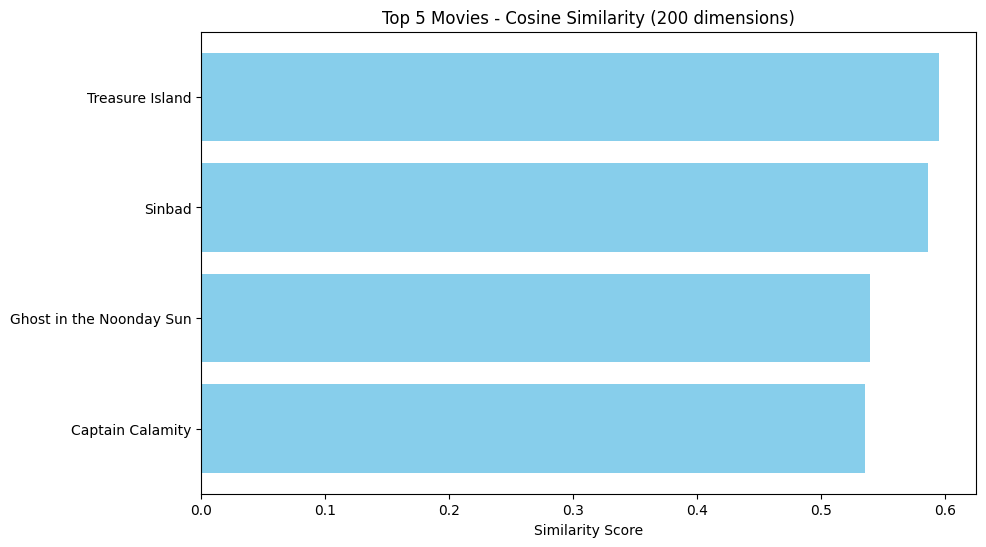

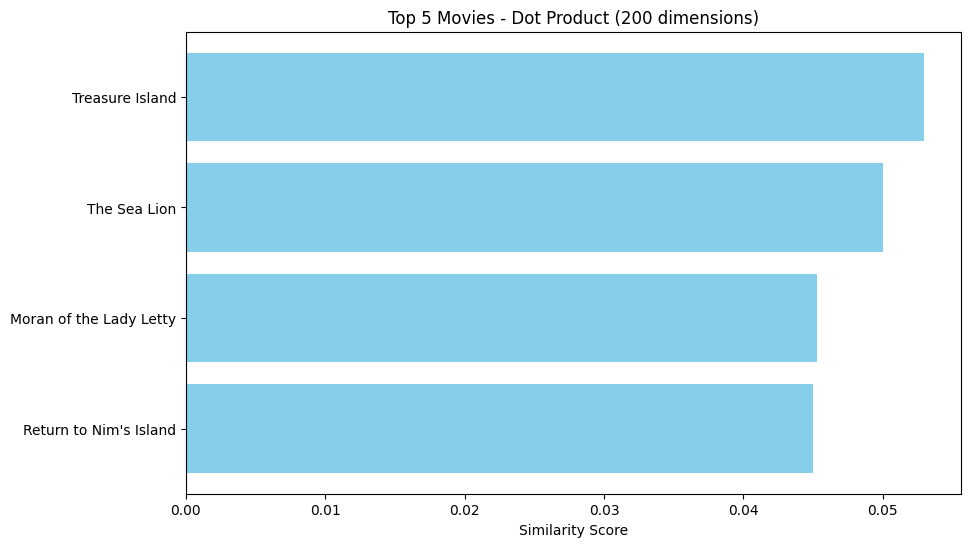

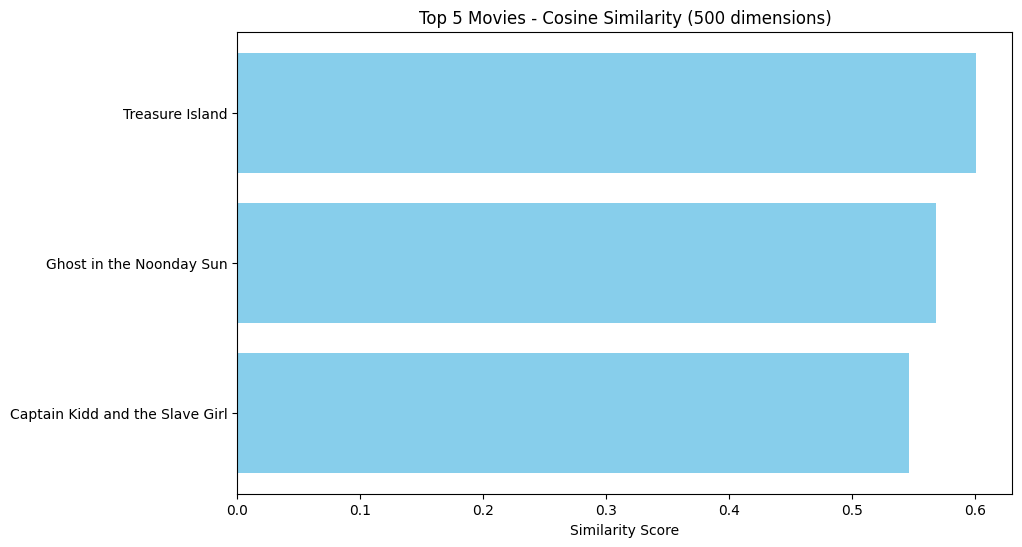

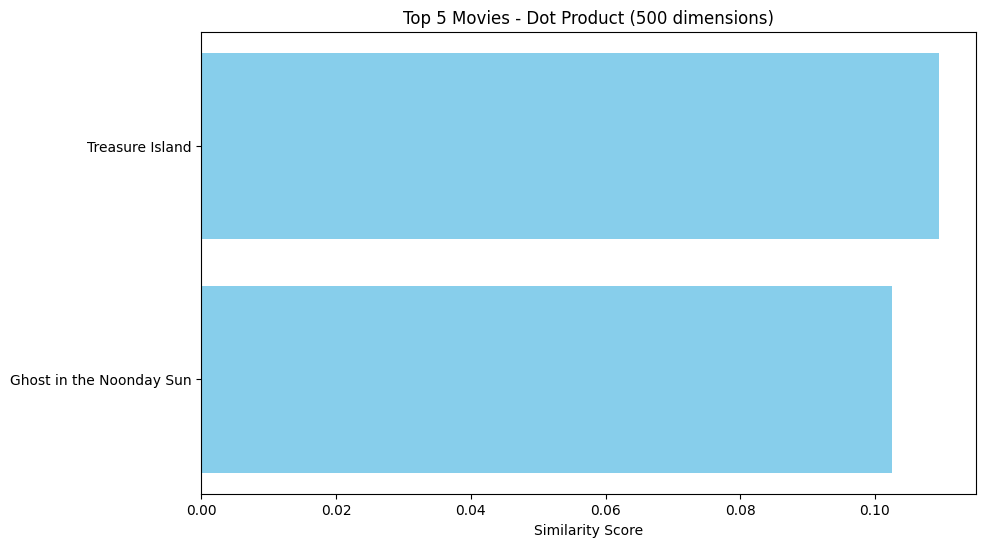

In [434]:
# Plot for 200 dimensions - Cosine similarity and Dot product
plot_top_similarities(cosine1_sim_200, "Top 5 Movies - Cosine Similarity (200 dimensions)")
plot_top_similarities(dot1_product_200, "Top 5 Movies - Dot Product (200 dimensions)")

# Plot for 500 dimensions - Cosine similarity and Dot product
plot_top_similarities(cosine1_sim_500, "Top 5 Movies - Cosine Similarity (500 dimensions)")
plot_top_similarities(dot1_product_500, "Top 5 Movies - Dot Product (500 dimensions)")

In [407]:
print(f"Top 5 Precision for \"Inspiring Pirate adventure\ Cosine 200 Dims")
print(f"Precision Value {4/4}\n")
print(f"Top 5 Precision for \"Inspiring Pirate adventure\ Dot 200 Dims")
print(f"Precision Value {4/4}\n")
print(f"Top 5 Precision for \"Inspiring Pirate adventure\ Cosine 500 Dims")
print(f"Precision Value {3/3}\n")
print(f"Top 5 Precision for \"Inspiring Pirate adventure\ Dot 500 Dims")
print(f"Precision Value {2/2}\n")

Top 5 Precision for "Inspiring Pirate adventure\ Cosine 200 Dims
Precision Value 1.0

Top 5 Precision for "Inspiring Pirate adventure\ Dot 200 Dims
Precision Value 1.0

Top 5 Precision for "Inspiring Pirate adventure\ Cosine 500 Dims
Precision Value 1.0

Top 5 Precision for "Inspiring Pirate adventure\ Dot 500 Dims
Precision Value 1.0



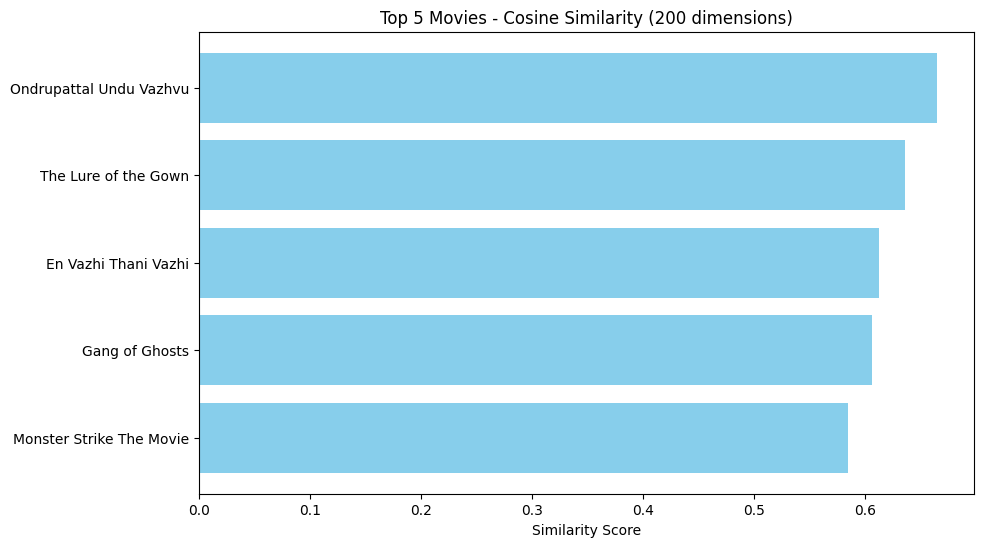

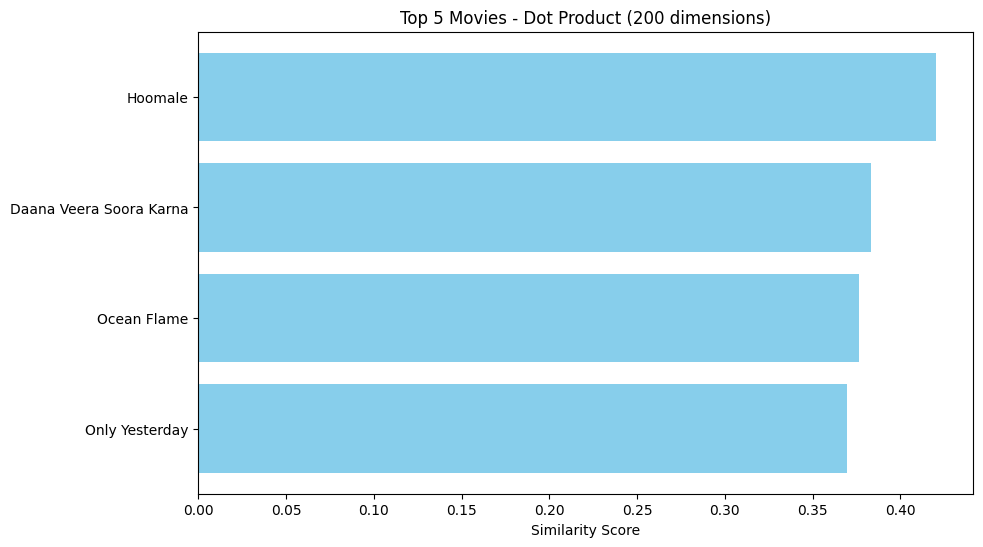

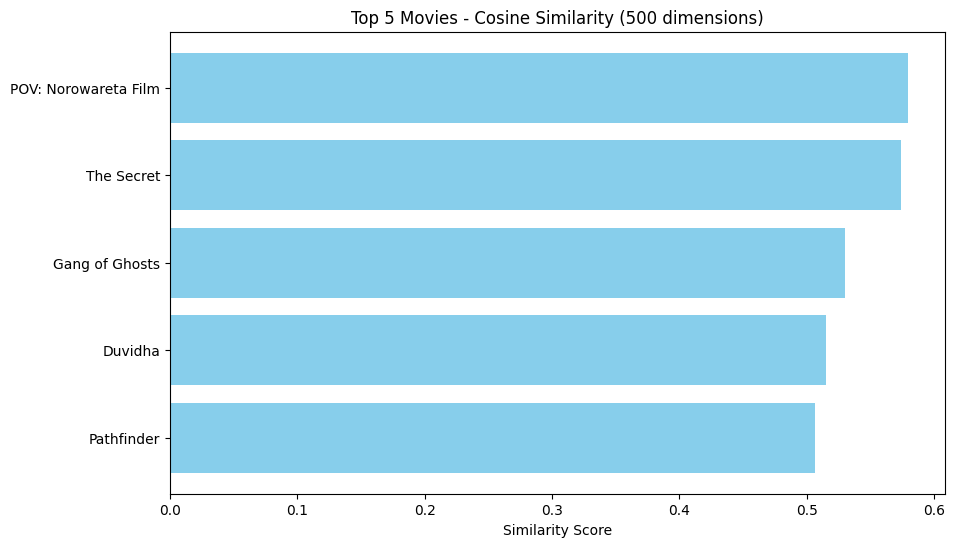

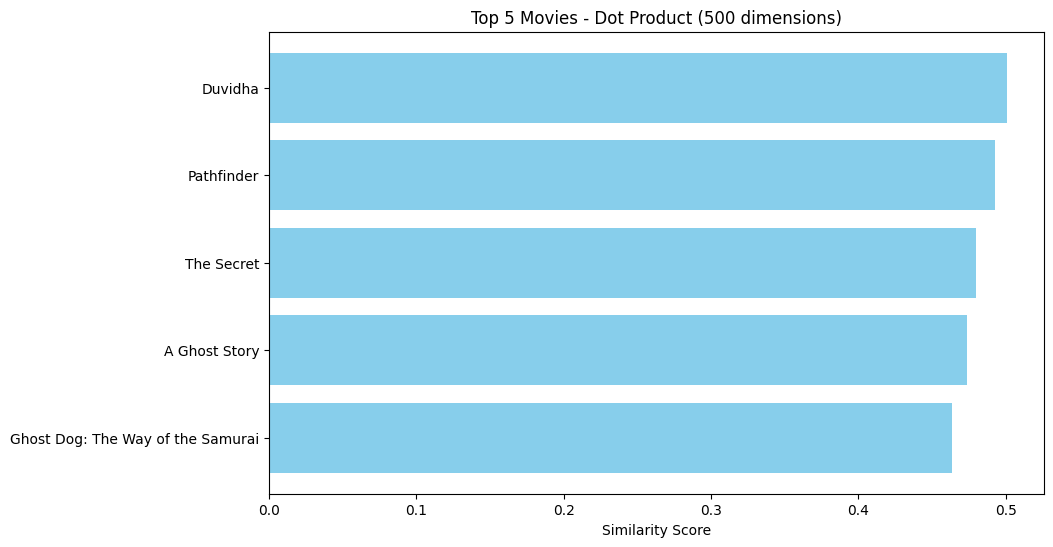

In [408]:
# Plot for 200 dimensions - Cosine similarity and Dot product
plot_top_similarities(cosine2_sim_200, "Top 5 Movies - Cosine Similarity (200 dimensions)")
plot_top_similarities(dot2_product_200, "Top 5 Movies - Dot Product (200 dimensions)")

# Plot for 500 dimensions - Cosine similarity and Dot product
plot_top_similarities(cosine2_sim_500, "Top 5 Movies - Cosine Similarity (500 dimensions)")
plot_top_similarities(dot2_product_500, "Top 5 Movies - Dot Product (500 dimensions)")

In [409]:
print(f"Top 5 Precision for \"Depressing Ghost Story\ Cosine 200 Dims")
print(f"Precision Value {1/5}\n")
print(f"Top 5 Precision for \"Depressing Ghost Story\ Dot 200 Dims")
print(f"Precision Value {1/4}\n")
print(f"Top 5 Precision for \"Depressing Ghost Story\ Cosine 500 Dims")
print(f"Precision Value {4/5}\n")
print(f"Top 5 Precision for \"Depressing Ghost Story\ Dot 500 Dims")
print(f"Precision Value {3/5}\n")

Top 5 Precision for "Depressing Ghost Story\ Cosine 200 Dims
Precision Value 0.2

Top 5 Precision for "Depressing Ghost Story\ Dot 200 Dims
Precision Value 0.25

Top 5 Precision for "Depressing Ghost Story\ Cosine 500 Dims
Precision Value 0.8

Top 5 Precision for "Depressing Ghost Story\ Dot 500 Dims
Precision Value 0.6



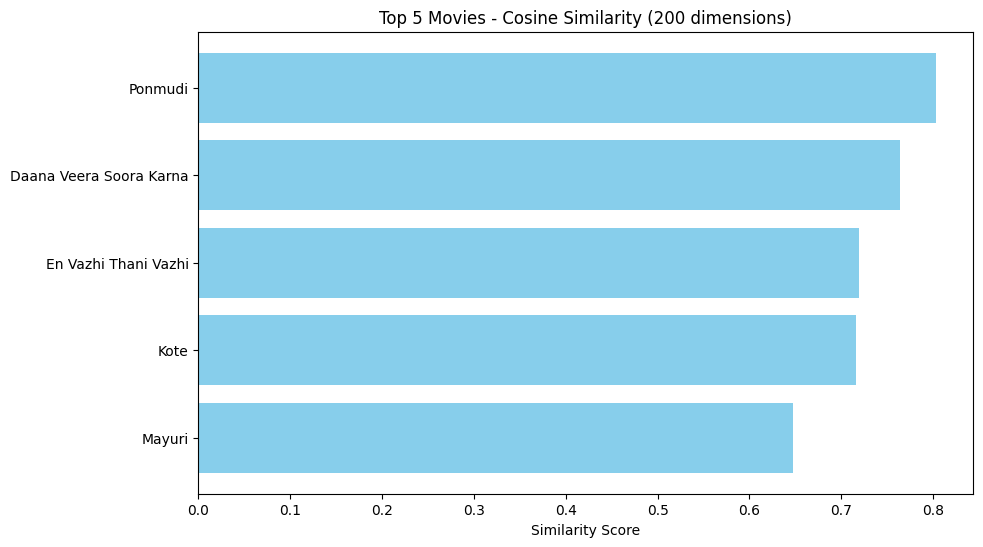

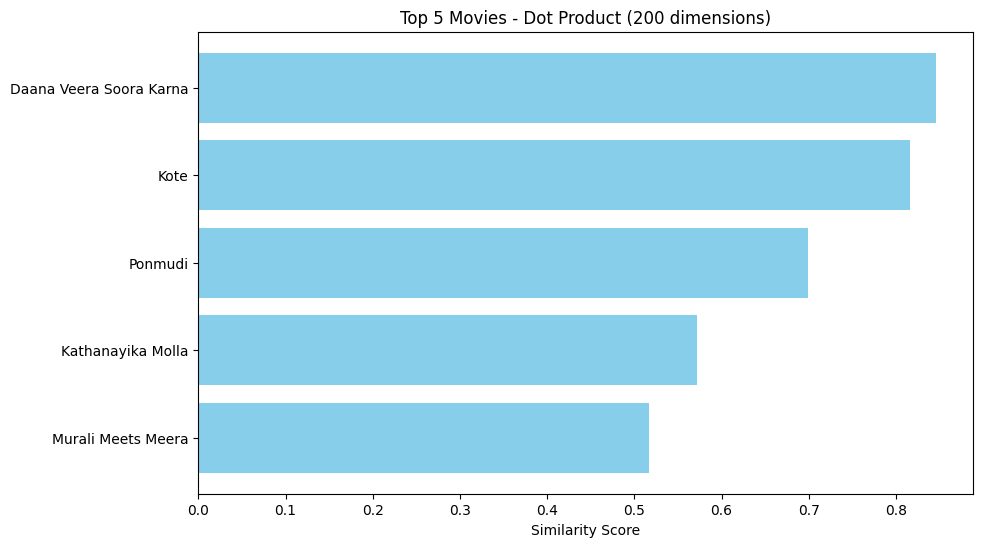

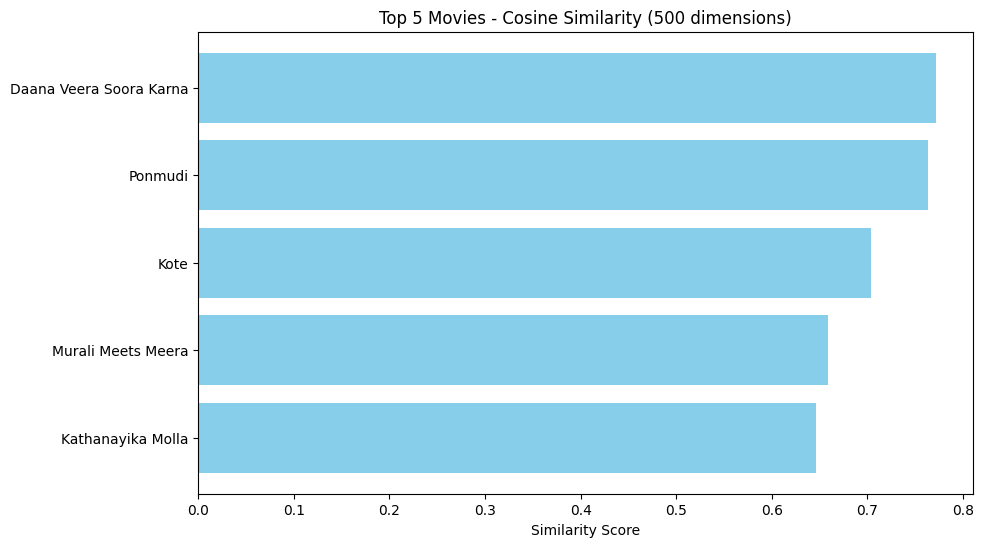

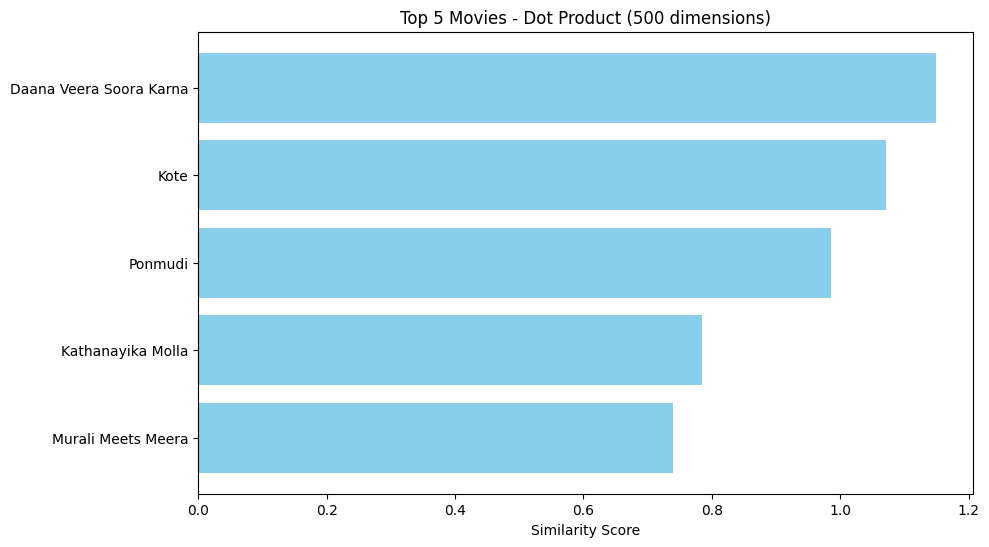

In [410]:
# Plot for 200 dimensions - Cosine similarity and Dot product
plot_top_similarities(cosine3_sim_200, "Top 5 Movies - Cosine Similarity (200 dimensions)")
plot_top_similarities(dot3_product_200, "Top 5 Movies - Dot Product (200 dimensions)")

# Plot for 500 dimensions - Cosine similarity and Dot product
plot_top_similarities(cosine3_sim_500, "Top 5 Movies - Cosine Similarity (500 dimensions)")
plot_top_similarities(dot3_product_500, "Top 5 Movies - Dot Product (500 dimensions)")

In [411]:
print(f"Top 5 Precision for \"Based on a True Story\ Cosine 200 Dims")
print(f"Precision Value {1/5}\n")
print(f"Top 5 Precision for \"Based on a True Story\ Dot 200 Dims")
print(f"Precision Value {2/5}\n")
print(f"Top 5 Precision for \"Based on a True Story\ Cosine 500 Dims")
print(f"Precision Value {2/5}\n")
print(f"Top 5 Precision for \"Based on a True Story\ Dot 500 Dims")
print(f"Precision Value {2/5}\n")

Top 5 Precision for "Based on a True Story\ Cosine 200 Dims
Precision Value 0.2

Top 5 Precision for "Based on a True Story\ Dot 200 Dims
Precision Value 0.4

Top 5 Precision for "Based on a True Story\ Cosine 500 Dims
Precision Value 0.4

Top 5 Precision for "Based on a True Story\ Dot 500 Dims
Precision Value 0.4



# Compare the precision results you got with clustering (Step 8) and without clustering (Step 9) for either tf or reduced SVD vector space. Comment on which clustering gave better results and why.